In [1]:
import sys
import os
from os import listdir
from os.path import isfile, join
sys.path.insert(0, join(os.getcwd(),os.pardir))
import json
import pandas as pd 

from recipe_1m_analysis.ingr_normalization import normalize_ingredient

In [2]:
PATH = "F:\\user\\Google Drive\\Catherning Folder\\THU\\Thesis\\Work\\Recipe datasets\\Yummly28"
PATH2 = "D:\\Documents\\Recipe datasets\\metadata27638_yummly28"
FOLDER_PATH = join(PATH,"metadata27638")
map_file = "map.txt"
raw_present = True

In [21]:
if not raw_present:
    files = [f for f in listdir(PATH2) if isfile(join(PATH2, f))]
    NB_RECIPE = len(files)
    recipes=[]
    for i in range(NB_RECIPE):
        with open(join(PATH2,files[i]),encoding="utf8") as json_file:
            dict_data = json.load(json_file)
        # TODO: use nutrition estimages, totalTime (in s?) in the future, 
        # useless keys for now:
        # "totalTime","source","images","id","totalTimeInSeconds",'attribution','nutritionEstimates','yield', "flavours", etc.

        list_ingr={}
        for ingr_raw in dict_data["ingredientLines"]:
            try:
                list_ingr.add(normalize_ingredient(ingr_raw).name)
            except:
                continue
        # use flavours etc.
        recipes.append({
            "id":i,
            "cuisine":dict_data["attributes"]["cuisine"][0],
            "ingredients":list(list_ingr),
            "all_ingredients":";".join(list_ingr)    
        })

    df = pd.DataFrame(recipes)
    df.to_pickle(join(PATH,"raw_data.pkl"))
else:
    df_train=pd.read_pickle(join(PATH,"raw_data.pkl"))
    df=df_train.reset_index()
    df=df.drop(columns=["index"])
    NB_RECIPES = len(df)

## Data cleaning for fusion with scirep regions

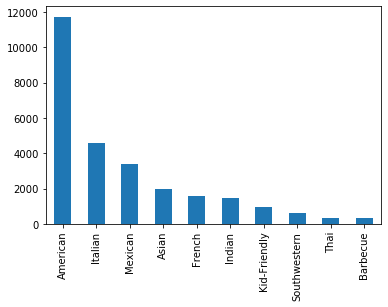

In [23]:
df['cuisine'].value_counts()
df_train['cuisine'].value_counts().head(10).plot(kind='bar')

In [24]:
# american : 11729 total 27638
11729/27638

0.4243794775309357

In [25]:
to_reverse = {"Mexico":"Mexican",
                           "mexico":"Mexican",
                           "chinese":"Chinese",
                           "China":"Chinese",
                           "France":"French",
                           "japanese":"Japanese",
                           "Japan":"Japanese",
                           "Thailand":"Thai",
                           "German":"Germany",
                           "India":"Indian",
                           "Israel":"Jewish",
                           "italian":"Italian",
                           "Italy":"Italian",
                           "Scandinavia":"Scandinavian",
                           "Vietnam":"Vietnamese",
                           "Korea":"Korean",
                           "korean":"Korean",
                           "EasternEuropean_Russian":"Eastern-Europe",
                           'Spain':'Spanish_Portuguese'}
replace_dict = {v:k for k,v in to_reverse.items()}

In [26]:
replace_dict_to_regions = {}
with open(os.path.join(PATH,map_file)) as f:
    for line in f:
        l = line.split()
        try:
            replace_dict_to_regions[l[0]]=l[1]
        except IndexError:
            pass

replace_dict["asian"]="Asian"
replace_dict["Southern & Soul Food"]="NorthAmerican"
replace_dict["Spanish"]="SouthernEuropean"
replace_dict["Cuban"]="LatinAmerican"
replace_dict["Cajun & Creole"]="NorthAmerican"
replace_dict["English"]="WesternEuropean"
replace_dict["Hawaiian"]="LatinAmerican"
replace_dict["Hungarian"]="WesternEuropean"
replace_dict["Portuguese"]="SouthernEuropean"

In [27]:
df["cuisine"]=df["cuisine"].replace(replace_dict)
df["cuisine"]=df["cuisine"].replace(replace_dict_to_regions)
df['cuisine'].value_counts()

NorthAmerican       12498
SouthernEuropean     4783
LatinAmerican        3430
Asian                1951
WesternEuropean      1584
SouthAsian           1457
Kid-Friendly          962
SoutheastAsian        348
Barbecue              338
EastAsian             276
African                11
Name: cuisine, dtype: int64

In [28]:
df = df[~df["cuisine"].isin(["Kid-Friendly","Barbecue"])]

In [29]:
df['cuisine'].value_counts()

NorthAmerican       12498
SouthernEuropean     4783
LatinAmerican        3430
Asian                1951
WesternEuropean      1584
SouthAsian           1457
SoutheastAsian        348
EastAsian             276
African                11
Name: cuisine, dtype: int64

## Removing cuisines with not enough recipes

In [30]:
RECIPE_THRESHOLD=10
cuisine_count= df['cuisine'].value_counts()
to_drop = [cuisine_count[cuisine_count == el].index[0] for el in cuisine_count if el<RECIPE_THRESHOLD]
df=df[~df["cuisine"].isin(to_drop)]

## Normalizing ingredients

In [32]:
df.to_pickle(join(PATH,"full_data.pkl"))